In [1]:
using Statistics
using DelimitedFiles
using Dates
using Flux
using MLDataUtils
using Random
using LinearAlgebra
using StatsBase
using Flux: onehotbatch, onecold, crossentropy, DataLoader
using Statistics
using Plots
using CSV
using DataFrames


In [2]:
# Probability function
function PSPACS(n, nbar, Ploss)
    if n == 0
        return 0
    elseif n == 1
        return ((exp(-nbar) / (1 + nbar)) * ((nbar ^ (n-1) / factorial(n - 1)) + (nbar * (nbar ^ (n - 2) / Inf)))) * (1 - Ploss)^nbar
    else
        return ((exp(-nbar) / (1 + nbar)) * ((nbar ^ (n-1) / factorial(n - 1)) + (nbar * (nbar ^ (n - 2) / factorial(n - 2))))) * (1 - Ploss)^nbar
    end
end

function PSPATS(n, nbar, Ploss)
    if n == 0
        return 0
    else
        return ((nbar ^ (n - 1) / (1 + nbar) ^ (n + 1)) * binomial(n, 1)) * (1 - Ploss)^nbar
    end
end

function dataGen(source, nbar, NExperiment, Ploss)
    # Zeros  = round(Int, NExperiment * source(0, nbar))
    Ones   = round(Int, NExperiment * source(1, nbar, Ploss))
    Twos   = round(Int, NExperiment * source(2, nbar, Ploss))
    Threes = round(Int, NExperiment * source(3, nbar, Ploss))
    Fours  = round(Int, NExperiment * source(4, nbar, Ploss))
    Fives  = round(Int, NExperiment * source(5, nbar, Ploss))
    Sixes  = round(Int, NExperiment * source(6, nbar, Ploss))

    data = []
    photonCounts = [Ones, Twos, Threes, Fours, Fives, Sixes]
    for i in 1:6
        photons =  zeros(photonCounts[i]) .+ (i)
        data = vcat(data, photons)
    end

    shuffle!(data)

    return data
end

function getProbs(data)
    return [count(x -> x == i, data) / size(data, 1) for i in 1:6]
end

function preprocess(spacs, spats, split)
    spacs = hcat(spacs, zeros(size(spacs, 1)))
    trainSpacs, testSpacs = spacs[1:Int(round(size(spacs, 1)*split)), :], spacs[Int(round(size(spacs, 1)*split))+1:end, :]
    spats = hcat(spats, ones(size(spats, 1)))
    trainSpats, testSpats = spats[1:Int(round(size(spats, 1)*split)), :], spats[Int(round(size(spats, 1)*split))+1:end, :]
    trainData = vcat(trainSpacs, trainSpats)
    testData = vcat(testSpacs, testSpats)
    trainData = trainData[shuffle(1:size(trainData, 1)), :]
    testData = testData[shuffle(1:size(testData, 1)), :]
    trainX, trainY, testX, testY = trainData[:, 1:end-1], trainData[:, end], testData[:, 1:end-1], testData[:, end]
    return trainX, trainY, testX, testY
end

function generateData(Ploss, binSize, nsamples, NExperiment, nbar, probs = false)
    spacs = dataGen(PSPACS, nbar, NExperiment, Ploss)
    spats = dataGen(PSPATS, nbar, NExperiment, Ploss)
    spacsData, spatsData = [], []
    spacsProbs, spatsProbs = [], []
    for _ in 1:nsamples
        sampleSpacs = sample(spacs, binSize)
        sampleSpats = sample(spats, binSize)
        spacsData = vcat(spacsData, [sampleSpacs])
        spatsData = vcat(spatsData, [sampleSpats])
        spacsProb, spatsProb = getProbs(sampleSpacs), getProbs(sampleSpats)
        spacsProbs = vcat(spacsProbs, [spacsProb])
        spatsProbs = vcat(spatsProbs, [spatsProb])
    end
    spacsData = hcat(map(x -> Float32.(x), spacsData)...)'
    spatsData = hcat(map(x -> Float32.(x), spatsData)...)'

    spacsProbs = hcat(map(x -> Float32.(x), spacsProbs)...)'
    spatsProbs = hcat(map(x -> Float32.(x), spatsProbs)...)'

    if probs
        spacsProbs = (spacsProbs .- mean(spacsProbs, dims=2)) ./ std(spacsProbs, dims=2)
        spatsProbs = (spatsProbs .- mean(spatsProbs, dims=2)) ./ std(spatsProbs, dims=2)
        return spacsProbs, spatsProbs
    else
        spacsData = spacsData ./ 6
        spatsData = spatsData ./6
        return spacsData, spatsData
    end
end

# Training function
function train!(model, trainData, testData, optimizer, epochs, loss)
    trainLosses, testLosses, trainAccuracies, testAccuracies = [], [], [], []
    for epoch in 1:epochs
        trainLoss, trainBatches, trainAccuracy, total = 0.0, 0, 0.0, 0
        for (x, y) in trainData
            grads = gradient(() -> loss(x, y), Flux.params(model))
            Flux.update!(optimizer, Flux.params(model), grads)
            trainBatches += 1
            total += size(x, 2)
            trainLoss += loss(x, y)
            predictions = model(x)
            trainAccuracy += sum(onecold(predictions) .== onecold(y))
            
        end
        trainLoss /= trainBatches
        trainAccuracy /= total
        push!(trainLosses, trainLoss)
        push!(trainAccuracies, trainAccuracy)

        testLoss, testBatches, testAccuracy, total = 0.0, 0, 0.0, 0
        for (x, y) in testData
            grads = gradient(() -> loss(x, y), Flux.params(model))
            Flux.update!(optimizer, Flux.params(model), grads)
            testBatches += 1
            total += size(x, 2)
            testLoss += loss(x, y)
            predictions = model(x)
            testAccuracy += sum(onecold(predictions) .== onecold(y))
            
        end
        testLoss /= testBatches
        testAccuracy /= total
        push!(testLosses, testLoss)
        push!(testAccuracies, testAccuracy)

    end

    return trainLosses, testLosses, trainAccuracies, testAccuracies
end

function run_exp(binSize, nsamples, NExperiment, nbar, epochs, lr, Ploss)
    spacs, spats = generateData(Ploss, binSize, nsamples, NExperiment, nbar)
    trainX, trainY, testX, testY = preprocess(spacs, spats, 0.75)
    trainY = onehotbatch(trainY, 0:1)
    testY = onehotbatch(testY, 0:1)

    # Define the model architecture
    if binSize > 60
        input_size = size(trainX, 2)  # Number of features
        hidden_size1 = 64  
        hidden_size2 = 16
        output_size = 2   # For binary classification
    else
        input_size = size(trainX, 2)  # Number of features
        hidden_size1 = 32  
        hidden_size2 = 16
        output_size = 2   # For binary classification
    end

    model = Chain(
        Dense(input_size, hidden_size1, relu),
        Dense(hidden_size1, hidden_size2, relu),
        Dense(hidden_size2, output_size),
        softmax
    )

    # Loss function
    loss(x, y) = crossentropy(model(x), y)
    optimizer = ADAM(lr)
    # Data in DataLoader for mini-batch gradient descent
    batch_size = 64
    train_data = DataLoader((trainX', trainY), batchsize=batch_size, shuffle=true)
    test_data = DataLoader((testX', testY), batchsize=batch_size)
    @info "Training Model"
    trainLosses, testLosses, trainAccuracies, testAccuracies = train!(model, train_data, test_data, optimizer, epochs, loss)
    return Dict("train" => trainLosses, "test"=>testLosses,), Dict("train"=>trainAccuracies, "test"=>testAccuracies), model
end

function run(binSize, nsamples, NExperiment, nbar, num_experiments, epochs, lr, Ploss)

    LOSS = Dict()
    ACCURACY = Dict()
    bestmodel = nothing
    for exp in 1:num_experiments
        @info "Running experiment $exp"
        losses, accuracies, model = run_exp(binSize, nsamples, NExperiment, nbar, epochs, lr, Ploss)
        if exp == 1
            LOSS = losses
            ACCURACY = accuracies
            bestmodel = model
        else
            LOSS["train"] = (LOSS["train"] .+ losses["train"]) ./ 2
            LOSS["test"] = (LOSS["test"] .+ losses["test"]) ./ 2
            ACCURACY["train"] = (ACCURACY["train"] .+ accuracies["train"])./ 2
            ACCURACY["test"] = (ACCURACY["test"] .+ accuracies["test"]) ./ 2
        end
    end

    return LOSS, ACCURACY, bestmodel
end



# for (i, nbar) in enumerate(nbars)
#     for (j, binSize) in enumerate(binSizes)
#         @info "nbar - $nbar ; bin size - $binSize"
#         loss, accuracy = run(binSize, nsamples, NExperiment, nbar, num_experiments, epochs, lr, Ploss)
#         CSV.write("results/baseline/loss_nbar$(nbar)_binSize$binSize.csv", DataFrame(loss))
#         CSV.write("results/baseline/accuracy_nbar$(nbar)_binSize$binSize.csv", DataFrame(accuracy))
#         push!(rls, loss)
#         push!(p, accuracy)
#         bestAccuracies[i, j] = maximum(accuracy["test"])
#     end
# end

# CSV.write("results/baseline/best_accuracies.csv", DataFrame(bestAccuracies, :auto))
# theme(:dark)
# p = scatter3d!(nbars, binSizes, bestAccuracies, title = "Classification Performance", xlabel="nbar", ylabel="bin size", zlabel="accuracy", label = "Test Accuracy")
# savefig("results/baseline/plot.png")



run (generic function with 1 method)

In [28]:
NExperiment = 1e8 + 4
nbars = [0.25, 0.33, 0.5, 0.66, 0.75]
binSizes = [10, 20, 40, 60, 80, 100, 200]
nsamples = 5000
num_experiments = 1
Ploss = 0.5
epochs = 1000
rls, p = [], []
bestAccuracies = zeros(Float32, size(nbars, 1), size(binSizes, 1))
lr = 0.001
binSize = 100
nbar = 0.05

0.05

In [29]:
loss, accuracy, model = run(binSize, nsamples, NExperiment, nbar, num_experiments, epochs, lr, Ploss)

┌ Info: Running experiment 1
└ @ Main /Users/advaitshukla/Documents/ANN/project/fresh/baseline.ipynb:174
┌ Info: Training Model
└ @ Main /Users/advaitshukla/Documents/ANN/project/fresh/baseline.ipynb:163


(Dict{String, Vector{Any}}("test" => [0.6943714201450348, 0.693764716386795, 0.6932194203138351, 0.6928167402744293, 0.6924876615405082, 0.6925242230296135, 0.6926826119422913, 0.6929206252098083, 0.6929995596408844, 0.691910733282566  …  0.4148804833181202, 0.423968665022403, 0.4238667903468013, 0.41774029219523073, 0.4146080064587295, 0.41862280704081056, 0.4176571074873209, 0.41339359544217585, 0.42957551004365085, 0.42208024598658084], "train" => [0.6940182002924257, 0.6926706221144078, 0.6929250273664119, 0.6928189412011938, 0.6925120333493766, 0.6925928173428875, 0.6918409507153398, 0.6914479914358107, 0.6918301344928095, 0.6921521283812442  …  0.48637554630384605, 0.48834457993507385, 0.48335153849448187, 0.48935706181041266, 0.4893244220796278, 0.49730063621270454, 0.48388049233767944, 0.47659357245695794, 0.4931682065381842, 0.49763489072605716]), Dict{String, Vector{Any}}("test" => [0.508, 0.4996, 0.5036, 0.5052, 0.5048, 0.5124, 0.5076, 0.5056, 0.5156, 0.4984  …  0.7776, 0.77

In [30]:
params = collect(Flux.params(model))[1]
numParams = sum(size(mat, 1) * size(mat, 2) for mat in params)
wtupdates = log(numParams * epochs)

15.671808548329901

In [9]:
plotloss = plot()
plotloss = plot!(title = "Feedforward Network", xlabels = "Parameter updates", ylabels = "Loss")
plotloss = plot!(0:wtupdates, loss["train"], label = "train", marker=:circle)
plotloss = plot!(0:wtupdates, loss["test"], label="test", marker=:circle)

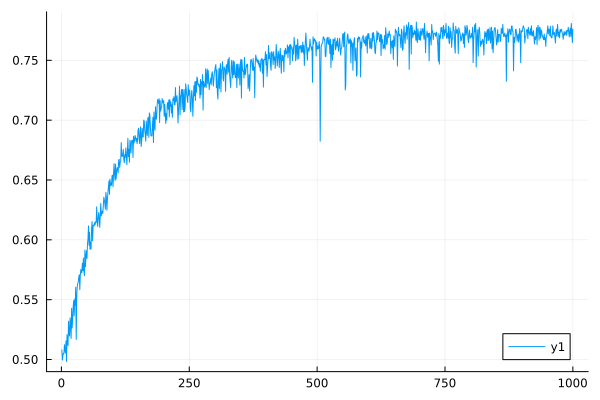

In [31]:
plot(1:epochs, accuracy["test"])

In [32]:
maximum(accuracy["test"])

0.782

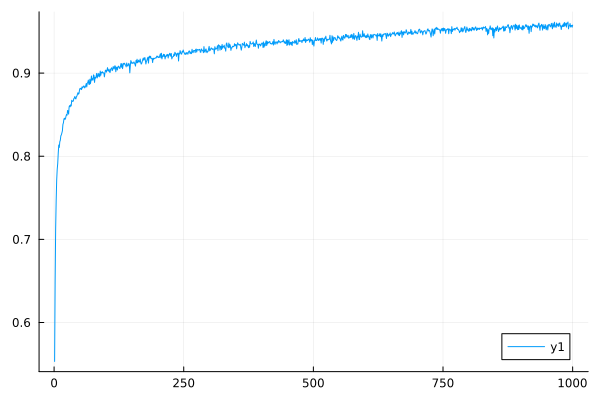

In [14]:
plot(1:epochs, accuracy["train"])